In [73]:
import pandas as pd
import re
import numpy as np
import thefuzz
import tqdm
import matplotlib.pyplot as plt
import requests
import json

pd.set_option('display.max_colwidth', None)

In [74]:
BE_df = pd.read_excel('../Daten/Vorhersagen/Katalogauszug und Vorhersagen.xlsx', index_col=0)

In [75]:
entry_df = pd.read_excel('../Daten/Katalogabgleich/Einträge.xlsx', index_col=0)

In [76]:
def prepare_string(string):
    new = re.sub(r'[àáâãå]', 'a', string)
    new = re.sub(r'[èéêë]', 'e', new)
    new = re.sub(r'[ìíîï]', 'i', new)
    new = re.sub(r'[òóôõ]', 'o', new)
    new = re.sub(r'[ùúû]', 'u', new)
    new = re.sub(r'æ', 'ae', new)
    new = re.sub('[.,:;()¬]|^[CLXVI]+? |^\d+? |^\d+?\.+? |^\.+ ?|= |# ', '', new)
    return new

entry_df['cleaned entry'] = entry_df['entry'].apply(lambda x: prepare_string(x))

In [6]:
BE_early = BE_df[BE_df['Anfang Veröffentlichungsdatum'] < 1736]
BE_early_no_dup = BE_early.drop_duplicates('Titel')
BE_no_year = BE_df[BE_df['Anfang Veröffentlichungsdatum'].isna()].drop_duplicates('Titel')
BE_manual = BE_df.loc[BE_early_no_dup.index.union(BE_no_year.index)]

In [7]:
BE_manual[BE_manual['Signatur'].str.contains('BE.1.T.33')].values

array([['BE.1.T.33', '+Z167651701',
        "Les deux livres de S. Augustin, de la veritable religion et des moeurs de l'eglise catholique, traduits en francois, sur l'edition latine des Peres Benedictins de la congregation de S. Maur",
        'Augustinus, Aurelius Heiliger 354-430', nan, 1693.0, nan,
        '1693', 'Paris', 'Paris', 'French', nan, nan, nan, nan, nan,
        'Z167651701', 'Z167651701_00000001.jpg', 'B', 0.0008314285660162,
        0.9985696077346802, 0.0003245634725317, 0.0002743884397204,
        'blue', 0.9836959838867188, 0.0060312687419354,
        0.0102726686745882]], dtype=object)

In [77]:
def search_in_entry(df, string):
    return df[df['cleaned entry'].str.contains(string)]

info = search_in_entry(search_in_entry(entry_df, 'Poille'), '')
print(len(info))
info

1


volume  page number category                       subcategory   
3508  14.377           98  Poëtica  Poëtæ Gallici unà cum Dramaticis  \

                  format handwritten page number       entry_ID   
3508  Octavo und kleiner                     502  14.377_098_09  \

                                                            entry   
3508  Poësies de Jacques Poille. Paris. 1623. Th. Blaise n. 1257.  \

                                              cleaned entry  
3508  Poesies de Jacques Poille Paris 1623 Th Blaise n 1257

In [368]:
entry_df.loc[2857]

volume                                                                                                                                     14.377
page number                                                                                                                                    28
category                                                                                                                                  Poëtica
subcategory                                                                                                                           Poëtæ Græci
format                                                                                                                         Octavo und kleiner
handwritten page number                                                                                                                       436
entry_ID                                                                                                                    

In [414]:
BE_entry = BE_df.loc[15975]
print(BE_entry['Signatur'])
print(BE_entry['Barcode'])
print(BE_entry['Titel'])
print(BE_entry['Autor'])
print(BE_entry['Veröffentlichungsort'])
print(BE_entry['Veröffentlichungsdatum'])
print(BE_entry['Wappenklassifizierung'])
BE_entry

BE.6.S.66
+Z201401009
Florus Danicus ; Otthiniae Impressus a Christiano Schrödero, Anno 1698
Bering, Vitus 1617-1675
Tyrnaviae
1716
N


Signatur                                                                                        BE.6.S.66
Barcode                                                                                       +Z201401009
Titel                              Florus Danicus ; Otthiniae Impressus a Christiano Schrödero, Anno 1698
Autor                                                                             Bering, Vitus 1617-1675
Mitwirkender                                                                                          NaN
Anfang Veröffentlichungsdatum                                                                      1716.0
Ende Veröffentlichungsdatum                                                                           NaN
Veröffentlichungsdatum                                                                               1716
Veröffentlichungsort                                                                            Tyrnaviae
Veröffentlichungsort (normiert)               

# Create Matching data

## Match from existing catalogue data for BE signatures. Combine author (+ printer etc), title, year and place and try to match it with an entry in the handwritten catalogue.

In [ ]:
better_matches = []
scorer = thefuzz.fuzz.token_set_ratio

for index, row in tqdm.notebook.tqdm(BE_manual.iterrows(), total=len(BE_manual)):
    keys = ['Autor', 'Mitwirkender', 'Titel', 'Veröffentlichungsort', 'Anfang Veröffentlichungsdatum']
    comb_string = ''
    for key in keys:
        val = row[key]
        if not pd.isna(val):
            if key == 'Autor' or key == 'Mitwirkender':
                if ',' in val:  # falls name, vorname
                    val = val.split(',')[0]
                val = val.split(' ')[0]
            elif key == 'Titel':
                val = prepare_string(val)
            elif key == 'Anfang Veröffentlichungsdatum':
                val = str(int(val))
            else: # key == 'Veröffentlichungsort'
                pass
            comb_string += val + ' '
    
    matches_lis = thefuzz.process.extract(comb_string, entry_df['cleaned entry'], scorer=scorer, limit=5)
    flat_matches = []
    for match in matches_lis:
        flat_matches.append(match[0])
        flat_matches.append(match[1])
        flat_matches.append(match[2])
    better_matches.append([comb_string] + flat_matches)

matches_df = pd.DataFrame(better_matches, columns=['input', 'match_1', 'score_1', 'id_1', 'match_2', 'score_2', 'id_2', 'match_3', 'score_3', 'id_3', 'match_4', 'score_4', 'id_4', 'match_5', 'score_5', 'id_5'])
matches_df['control'] = ''
matches_df

In [ ]:
matches_df_no_score = matches_df.drop(['score_1', 'score_2', 'score_3', 'score_4', 'score_5'], axis=1)
matches_df_no_score.insert(1, 'input_id', BE_manual.index)
matches_df_no_score

In [749]:
# Export in batches of 1000
matches_df_no_score[:1000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_1000.xlsx', index=False)
matches_df_no_score[1000:2000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_2000.xlsx', index=False)
matches_df_no_score[2000:3000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_3000.xlsx', index=False)
matches_df_no_score[3000:4000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_4000.xlsx', index=False)
matches_df_no_score[4000:5000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_5000.xlsx', index=False)
matches_df_no_score[5000:6000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_6000.xlsx', index=False)
matches_df_no_score[6000:7000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_7000.xlsx', index=False)
matches_df_no_score[7000:8000].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_8000.xlsx', index=False)
matches_df_no_score[8000:].to_excel('../Daten/Katalogabgleich/Kandidaten/Kandidaten_8756.xlsx', index=False)

In [3]:
non_BE = BE_df[~BE_df['Signatur'].str.contains('BE')]
non_BE_wappen = non_BE[~non_BE['Wappenklassifizierung'].isna()]

In [34]:
non_BE_wappen[['Signatur', 'Wappenklassifizierung', 'Barcode', 'Mitwirkender']]

Signatur Wappenklassifizierung      Barcode  \
22595  Be.10.J.38.(Vol.1,1)                     N  +Z17136510X   
22599     Be.5.Q.69.(Vol.5)                     N  +Z197357203   
22612               22.M.23                     B   +Z43165504   
22613               22.N.14                     B  +Z221977709   
22614       22.N.27 (Vol.1)                     B   +Z43162801   
22615               22.N.67                     B  +Z221954400   
22616               22.Q.37                     N  +Z22196790X   
22618             60164-D.1                     A  +Z194791901   
22619             60164-D.2                     A  +Z254932002   

                                                                                                                                                                              Mitwirkender  
22595                                                                                  Cotta; Nees von Esenbeck, Christian Gottfried Daniel 1776-1858; Eschweiler, Franz Gerhard 1796-1831  
22599                                                                                                                                                                                  NaN  
22612        Manuzio, Aldo Pio 1450-1515; Philostratus, Flavius 160-245; Eusebius Caesariensis 260-339; Rinuccinus, Alemannus 1426-1504; Acciaiuoli, Zanobi 1461-1519; Ευσεβιος Καισαρειας  
22613                                                                                                                                             Manuzio, Paolo; Manuzio, Paolo 1512-1574  
22614  Manuzio, Aldo Pio 1450-1515; Theophanes Confessor 752-817; Cosmas Hierosolymitanus -781; Marcus de Idronto ca. um 770; Johannes Damascenus 675-749; Clarius, Daniel ca. 15./16. Jh.  
22615                                                                                                                                       Manuzio, Paolo 1512-1574; Auria, Andrea <<d'>>  
22616                                                                                                           Asulanus, Franciscus -1546; Aldo Manuzio Senior Haeredes; Carloni, Antonio  
22618                                                                                                                                                                                  NaN  
22619                                                                                                                                                                                  NaN

In [33]:
non_BE_wappen.columns

Index(['Signatur', 'Barcode', 'Titel', 'Autor', 'Mitwirkender',
       'Anfang Veröffentlichungsdatum', 'Ende Veröffentlichungsdatum',
       'Veröffentlichungsdatum', 'Veröffentlichungsort',
       'Veröffentlichungsort (normiert)', 'Sprache', 'Schlagwörter',
       'Schlagwörter (mit GND)', 'Vorbesitzer', 'Typ', 'Bemerkungen',
       'Gültiger Barcode', 'Dateiname', 'Wappenklassifizierung', 'p_A', 'p_B',
       'p_C', 'p_N', 'Farbklassifizierung', 'p_blue', 'p_red', 'p_yellow'],
      dtype='object')

In [79]:
pred = pd.read_csv('../Daten/Vorhersagen/catalogue_pred_combined.csv')
pred.columns

Index(['filename', 'prediction', 'p_A', 'p_B', 'p_C', 'p_N', 'color', 'p_blue',
       'p_red', 'p_yellow', 'man_prediction', 'man_color', 'valid_bc',
       'Permanent Call Number', '992', '993', '695', '866',
       'Library Code (Active)', 'Location Code', 'Barcode', 'Item Call Number',
       'Title', 'Author', 'Author (contributor)', 'Begin Publication Date',
       'End Publication Date', 'Publication Date', 'Publication Place',
       'Publisher', 'Unnamed: 17', 'MMS Id', '856', 'Subjects',
       'Subjects (Names)'],
      dtype='object')

In [80]:
no_sign_wappen = pred[pred['Permanent Call Number'].isna()]

In [81]:
len(no_sign_wappen)

803

In [82]:
no_sign_wappen

filename prediction       p_A       p_B       p_C  \
0     Z103519105_00000001.jpg          A  0.998598  0.000445  0.000400   
4     Z10353460X_00000001.jpg          A  0.994711  0.002387  0.001679   
13    Z105561605_00000001.jpg          B  0.000142  0.999590  0.000070   
16    Z137115906_00000001.jpg          A  0.997722  0.001312  0.000461   
17    Z13711690X_00000001.jpg          A  0.999452  0.000185  0.000149   
...                       ...        ...       ...       ...       ...   
6154  Z260077107_00000001.jpg          B  0.000248  0.998484  0.000442   
6155   Z43162801_00000001.jpg          B  0.000684  0.997634  0.001180   
6156   Z43163301_00000001.jpg          B  0.000872  0.998139  0.000583   
6157   Z43165504_00000001.jpg          B  0.000670  0.998324  0.000560   
6158   Z43169509_00000001.jpg          A  0.995156  0.001711  0.002191   

           p_N color    p_blue     p_red  p_yellow  ...  \
0     0.000558   red  0.000419  0.997730  0.001851  ...   
4     0.001224   red  0.002559  0.982544  0.014897  ...   
13    0.000198   red  0.000502  0.995507  0.003991  ...   
16    0.000505  blue  0.993158  0.003776  0.003066  ...   
17    0.000213  blue  0.994273  0.005353  0.000374  ...   
...        ...   ...       ...       ...       ...  ...   
6154  0.000827   red  0.000213  0.994317  0.005469  ...   
6155  0.000502   red  0.001450  0.997198  0.001353  ...   
6156  0.000406   red  0.000331  0.998473  0.001197  ...   
6157  0.000445   red  0.001188  0.996374  0.002438  ...   
6158  0.000941   red  0.000120  0.999710  0.000170  ...   

     Begin Publication Date End Publication Date Publication Date  \
0                       NaN                  NaN              NaN   
4                       NaN                  NaN              NaN   
13                      NaN                  NaN              NaN   
16                      NaN                  NaN              NaN   
17                      NaN                  NaN              NaN   
...                     ...                  ...              ...   
6154                    NaN                  NaN              NaN   
6155                    NaN                  NaN              NaN   
6156                    NaN                  NaN              NaN   
6157                    NaN                  NaN              NaN   
6158                    NaN                  NaN              NaN   

     Publication Place Publisher Unnamed: 17 MMS Id  856 Subjects  \
0                  NaN       NaN         NaN    NaN  NaN      NaN   
4                  NaN       NaN         NaN    NaN  NaN      NaN   
13                 NaN       NaN         NaN    NaN  NaN      NaN   
16                 NaN       NaN         NaN    NaN  NaN      NaN   
17                 NaN       NaN         NaN    NaN  NaN      NaN   
...                ...       ...         ...    ...  ...      ...   
6154               NaN       NaN         NaN    NaN  NaN      NaN   
6155               NaN       NaN         NaN    NaN  NaN      NaN   
6156               NaN       NaN         NaN    NaN  NaN      NaN   
6157               NaN       NaN         NaN    NaN  NaN      NaN   
6158               NaN       NaN         NaN    NaN  NaN      NaN   

     Subjects (Names)  
0                 NaN  
4                 NaN  
13                NaN  
16                NaN  
17                NaN  
...               ...  
6154              NaN  
6155              NaN  
6156              NaN  
6157              NaN  
6158              NaN  

[803 rows x 35 columns]

In [98]:
nsw = no_sign_wappen.dropna(axis=1)

In [99]:
def get_content(url):
    retries = 0
    while retries < 3:
        try:
            resp = requests.get(url)
            if resp.status_code == 200:
                return resp.content
            else:
                retries += 1
        except requests.exceptions.Timeout:
            retries += 1
        except (requests.exceptions.TooManyRedirects, requests.exceptions.RequestException) as e:
            raise SystemExit(e)

def extract_signature_from_manifest(bc):
    man_url = f'https://iiif.onb.ac.at/presentation/ABO/{bc}/manifest'
    metadata = json.loads(get_content(man_url))['metadata']
    metadata_str = json.dumps(metadata)
    loc_s = re.compile('<a.+?data.onb.ac.at.+?>(.+?)</a>')
    ac_s = re.compile('AC[0-9]+')
    loc = loc_s.findall(metadata_str)
    if len(loc) > 0:
        loc = loc[0]
    else:
        loc = ''
    acnr = ac_s.findall(metadata_str)
    if len(acnr) > 0:
        acnr = acnr[0]
    else:
        acnr = ''
    return (loc, acnr)

In [100]:
extract_signature_from_manifest('Z150809200')

('', 'AC09912489')

In [101]:
for i in nsw.index:
    bc = nsw.loc[i, 'valid_bc']
    sig, ac = extract_signature_from_manifest(bc)
    nsw.loc[i, 'Signatur'] = sig
    nsw.loc[i, 'AC-Nummer'] = ac

/tmp/ipykernel_7044/501467936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw.loc[i, 'Signatur'] = sig
/tmp/ipykernel_7044/501467936.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw.loc[i, 'AC-Nummer'] = ac


In [105]:
nsw_no_dup = nsw.drop_duplicates('valid_bc')

In [110]:
keine_BE = nsw_no_dup.drop(['filename', 'prediction', 'p_A', 'p_B', 'p_C', 'p_N', 'color', 'p_blue', 'p_red', 'p_yellow'], axis=1)

In [114]:
keine_BE.rename(columns={'man_prediction': 'Wappen', 'man_color': 'Einbandfarbe', 'valid_bc': 'Barcode'}, inplace=True)

In [116]:
keine_BE = keine_BE.reindex(columns=['Barcode', 'Signatur', 'AC-Nummer', 'Wappen', 'Einbandfarbe'])

In [121]:
keine_BE.to_excel('../Daten/Vorhersagen/Eugeniana aber nicht BE.xlsx', index=None)

# Analyze manual matching data

In [78]:
manual_file_names = [
    'Ausgefüllt_1000.xlsx',
    'Ausgefüllt_2000.xlsx',
    'Ausgefüllt_3000.xlsx',
    'Ausgefüllt_4000.xlsx',
    'Ausgefüllt_5000.xlsx',
    'Ausgefüllt_6000.xlsx',
    'Ausgefüllt_7000.xlsx',
    'Ausgefüllt_8000.xlsx',
    'Ausgefüllt_8756.xlsx',
]

manual_matches_dfs = []

for fname in manual_file_names:
    df = pd.read_excel(f'../Daten/Katalogabgleich/Ausgefüllt/{fname}')
    manual_matches_dfs.append(df)

man_matches = pd.concat(manual_matches_dfs, ignore_index=True)

In [79]:
has_hw_catalog = man_matches.dropna(subset=['control'])

## Matching statistics

In [81]:
def num_in_lis(num, lis_str):
    if pd.isna(lis_str):
        return False 
    else:
        if isinstance(lis_str, int):
            lis = [lis_str]
        if isinstance(lis_str, str):
            if '?' in lis_str:
                return False
            lis = lis_str.split(', ')
            lis = [int(n) for n in lis]
        return num in lis

example = man_matches.loc[9]
print(example['id_1'], type(example['id_1']))
print(example['control'], type(example['control']))
print(num_in_lis(example['id_1'], example['control']))

75 <class 'numpy.int64'>
75 <class 'int'>
True


In [108]:
BE_signatures_matched = len(man_matches.dropna(subset=['control']))
print(BE_signatures_matched, 'out of', len(man_matches), 'BE signatures from the appropriate time period were matched')

first_matches = sum(man_matches.apply(lambda x: num_in_lis(x['id_1'], x['control']), axis=1))
print('For', first_matches, 'matches the first one was correct')
any_matches = sum(man_matches.apply(lambda x: num_in_lis(x['id_1'], x['control']) 
                                    or num_in_lis(x['id_2'], x['control']) 
                                    or num_in_lis(x['id_3'], x['control']) 
                                    or num_in_lis(x['id_4'], x['control']) 
                                    or num_in_lis(x['id_5'], x['control']), axis=1))
print('For', any_matches, 'matches one of the five given ones in the table was correct')

double_matches = man_matches['control'].str.contains(',').sum()
print(double_matches, 'matches have two or more mentions in the handrwitten catalog')

5778 out of 8756 BE signatures from the appropriate time period were matched
For 4564 matches the first one was correct
For 5072 matches one of the five given ones in the table was correct
124 matches have two or more mentions in the handrwitten catalog


In [83]:
num_re = re.compile('\d{1,4}(?!\?)')
all_matches = []
for row in man_matches['control']:
    match = num_re.findall(str(row))
    if match:
        all_matches.append(match)

flat_matches = [el for sublis in all_matches for el in sublis]
set_matches = set(flat_matches)

In [84]:
unique_matches_int = sorted([int(n) for n in set_matches])

print(len(unique_matches_int), 'entries out of', len(entry_df), 'entries from the handwritten catalog were matched (at least once)')
unique_matches_int[:20]

5086 entries out of 9403 entries from the handwritten catalog were matched (at least once)


[2, 4, 7, 9, 10, 11, 12, 14, 16, 18, 19, 20, 22, 25, 26, 28, 29, 32, 34, 35]

In [111]:
no_matches_df = entry_df.loc[entry_df.index.difference(unique_matches_int)]
matches_df = entry_df.loc[unique_matches_int]

In [136]:
all_counts = entry_df['category'].value_counts()
match_counts = matches_df['category'].value_counts()
no_match_counts = no_matches_df['category'].value_counts()

ratios = {}
for cat, count in all_counts.items():
    matched = 0
    if cat in match_counts.index:
        matched = match_counts[cat]
    ratios[cat] = matched / count

print(ratios)

{'Historia Nova Europæ': 0.48382838283828383, 'Poëtica': 0.5410273515677118, 'Paralipomena Historica': 0.5508870214752568, 'Theologia': 0.7555555555555555, 'Philologia': 0.596694214876033, 'Historia Naturalis': 0.6634615384615384, 'Historia Ecclesiastica': 0.689119170984456, 'Artes': 0.5623342175066313, 'Philosophia': 0.6542857142857142, 'Historia Antiqua': 0.3862928348909657, 'Codices Manuscripti': 0.0034129692832764505, 'Imagines Incisæ': 0.04330708661417323, 'Geographia': 0.5317460317460317, 'Iurisprudentia': 0.6715686274509803, 'Historia Nova extra Europam': 0.5577889447236181, 'Rhetorica': 0.5864197530864198, 'Mathematica': 0.7559055118110236, 'Grammatica': 0.5819672131147541, 'Medicina': 0.6330275229357798, 'Chronologia': 0.5612244897959183, 'Miscellanea Historica': 0.3877551020408163, 'Imagines Variæ Incisæ': 0.0851063829787234, 'Effigierum Incisarum Collectio': 0.0, 'Imaginum Delineatarum Collectio': 0.0}


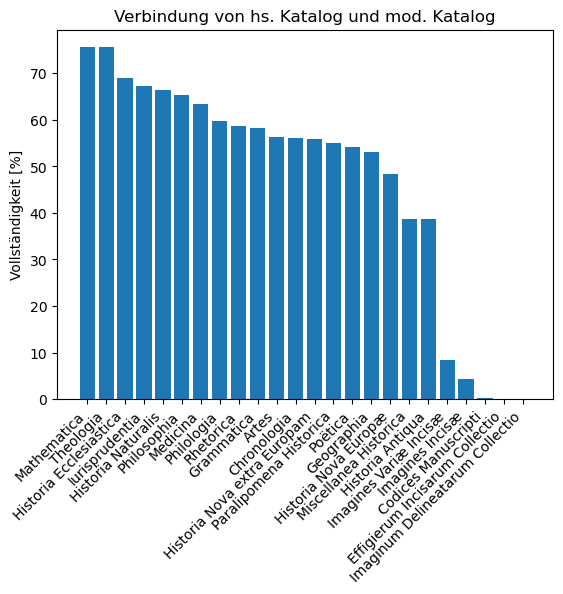

In [170]:
sorted_ratios = sorted(ratios.items(), key=lambda x: x[1], reverse=True)
n, r = list(zip(*sorted_ratios))

fix, ax = plt.subplots()
ax.bar(n, [100 * ratio for ratio in r])
plt.xticks(rotation=45, ha='right')
ax.set_ylabel('Vollständigkeit [%]')
ax.set_title('Verbindung von hs. Katalog und mod. Katalog')
plt.show()

## Add new matching data to existing catalogue data

In [171]:
BE_df = pd.read_excel('../Daten/Vorhersagen/WIP_complete_BE.xlsx', index_col=0)

In [172]:
# volume 	page number 	category 	subcategory 	format 	handwritten page number 	entry_ID 	entry 	
BE_df['hs. Katalog'] = 0

BE_df.columns

Index(['Barcode', 'Titel', 'Autor', 'Mitwirkender',
       'Anfang Veröffentlichungsdatum', 'Ende Veröffentlichungsdatum',
       'Veröffentlichungsdatum', 'Veröffentlichungsort',
       'Veröffentlichungsort (normiert)', 'Sprache', 'Schlagwörter',
       'Schlagwörter (mit GND)', 'Vorbesitzer', 'Typ', 'Bemerkungen',
       'Gültiger Barcode', 'Dateiname', 'Wappenklassifizierung', 'p_A', 'p_B',
       'p_C', 'p_N', 'Farbklassifizierung', 'p_blue', 'p_red', 'p_yellow',
       'hs. Katalog', 'hs. Katalog Konfidenz', 'hs. Katalogband',
       'hs. Katalogseite Digitalisat', 'Wissensklasse', 'Wissensunterklasse',
       'Formatangabe', 'hs. Katalogseite Handschrift', 'hs. Katalogeintrag ID',
       'hs. Katalogeintrag', 'hs. Katalog Image URL', 'identifier',
       'ABO-Barcode'],
      dtype='object')

In [173]:
entry_df.columns

Index(['volume', 'page number', 'category', 'subcategory', 'format',
       'handwritten page number', 'entry_ID', 'entry', 'cleaned entry'],
      dtype='object')

In [ ]:
dod_id = {
    '14.376': 51202, 
    '14.377': 51184,
    '14.378': 51219
}

for i, entry in has_hw_catalog.iterrows():
    man_match = str(entry['control'])
    match_regex = re.compile('\d{1,4}')
    matches = match_regex.findall(man_match)
    if matches:
        first_match_id = int(matches[0])
        corr_entry = entry_df.loc[first_match_id]
        BE_id = entry['input_id']
        BE_df.at[BE_id, 'hs. Katalog'] = 1
        if '?' not in man_match:
            BE_df.at[BE_id, 'hs. Katalog Konfidenz'] = 'sicher'
        else:
            BE_df.at[BE_id, 'hs. Katalog Konfidenz'] = 'unsicher'
        BE_df.at[BE_id, 'hs. Katalogband'] = str(corr_entry['volume'])
        BE_df.at[BE_id, 'hs. Katalogseite Digitalisat'] = corr_entry['page number']
        BE_df.at[BE_id, 'Wissensklasse'] = corr_entry['category']
        BE_df.at[BE_id, 'Wissensunterklasse'] = corr_entry['subcategory']
        BE_df.at[BE_id, 'Formatangabe'] = corr_entry['format']
        BE_df.at[BE_id, 'hs. Katalogseite Handschrift'] = corr_entry['handwritten page number']
        BE_df.at[BE_id, 'hs. Katalogeintrag ID'] = corr_entry['entry_ID']
        BE_df.at[BE_id, 'hs. Katalogeintrag'] = corr_entry['entry']
        BE_df.at[BE_id, 'hs. Katalog Image URL'] = f"https://iiif.onb.ac.at/images/DOD/{dod_id[str(corr_entry['volume'])]}/{corr_entry['page number']:08}.jp2/full/full/0/native.jpg"

In [91]:
# BE_df.to_excel('../Daten/Vorhersagen/Katalogauszug, Vorhersagen und hs. Katalogverbindungen.xlsx', index=False)
BE_df.to_excel('../Daten/Vorhersagen/Complete_BE.xlsx', index=False)

In [92]:
BE_df.columns

Index(['Signatur', 'Barcode', 'Titel', 'Autor', 'Mitwirkender',
       'Anfang Veröffentlichungsdatum', 'Ende Veröffentlichungsdatum',
       'Veröffentlichungsdatum', 'Veröffentlichungsort',
       'Veröffentlichungsort (normiert)', 'Sprache', 'Schlagwörter',
       'Schlagwörter (mit GND)', 'Vorbesitzer', 'Typ', 'Bemerkungen',
       'Gültiger Barcode', 'Dateiname', 'Wappenklassifizierung', 'p_A', 'p_B',
       'p_C', 'p_N', 'Farbklassifizierung', 'p_blue', 'p_red', 'p_yellow',
       'hs. Katalog', 'hs. Katalog Konfidenz', 'hs. Katalogband',
       'hs. Katalogseite Digitalisat', 'Wissensklasse', 'Wissensunterklasse',
       'Formatangabe', 'hs. Katalogseite Handschrift', 'hs. Katalogeintrag ID',
       'hs. Katalogeintrag', 'hs. Katalog Image URL'],
      dtype='object')

# Eugeniana-Inkunabeln aus dem handschriftlichen Katalog extrahieren

In [513]:
def extract_four_digit_number(entry):
    four_dig_re = re.compile('(?<! [pPnN] )\d{4}')
    match = four_dig_re.findall(entry)
    if match:
        return [int(x) for x in match]
    else:
        return []

year_samples = [
    'Vossij Isaaci Dissertationes de 70 Interpretum tralatione & Chronologia Hagae Comp 1661 Vlacq p 7145 n 1360',
    'Biblia Sacra graece ac latine juxta 70 Interpretes 3 Vol charta magna Paris 1628 Nic Buon N 3743',
    'Nummi Antiqui Familiarum Romanar cum Ioannis Vaillant Interpretationibus 2 Vol Amsteln 1703 Gallet n 5925 5926',
    'Hulsij antonij Authentia absoluta Seu textus hebraei vindicata contra criminationes Isaaci Vossii in libro recens edito de 70 Interpretum tralatione cum binis epistolis Roterod 1662 arn Leers n 2407 P 1234'
]

for entry in year_samples:
    print(extract_four_digit_number(entry))

[1661]
[1628]
[1703, 5926]
[1662]


In [497]:
entry_df['years'] = entry_df['cleaned entry'].apply(lambda x: extract_four_digit_number(x))

In [498]:
years_raw = entry_df['years']

In [518]:
years_raw

0             [1515]
1             [1572]
2       [1637, 1669]
3             [1462]
4             [1472]
            ...     
9398              []
9399              []
9400              []
9401              []
9402              []
Name: years, Length: 9403, dtype: object

In [519]:
years_cleaned = years_raw.apply(lambda x: list(filter(lambda y: 1400 < int(y) < 1736, x)))

In [520]:
years_min = years_cleaned.apply(lambda x: int(min(x)) if len(x) else np.nan)

In [521]:
without_years = entry_df.loc[years_raw[years_min.isna()].index]

In [522]:
years_min

0       1515.0
1       1572.0
2       1637.0
3       1462.0
4       1472.0
         ...  
9398       NaN
9399       NaN
9400       NaN
9401       NaN
9402       NaN
Name: years, Length: 9403, dtype: float64

In [523]:
before_1501 = entry_df.loc[years_min < 1501]

In [526]:
before_1501

volume  page number             category   
3     14.376           25            Theologia  \
4     14.376           25            Theologia   
6     14.376           25            Theologia   
7     14.376           25            Theologia   
8     14.376           26            Theologia   
...      ...          ...                  ...   
9017  14.378          522  Codices Manuscripti   
9033  14.378          523  Codices Manuscripti   
9051  14.378          527  Codices Manuscripti   
9052  14.378          528  Codices Manuscripti   
9059  14.378          529  Codices Manuscripti   

                             subcategory              format   
3     Textus & Versiones Sacræ Scripturæ               Folio  \
4     Textus & Versiones Sacræ Scripturæ               Folio   
6     Textus & Versiones Sacræ Scripturæ               Folio   
7     Textus & Versiones Sacræ Scripturæ               Folio   
8     Textus & Versiones Sacræ Scripturæ               Folio   
...                                  ...                 ...   
9017                                 NaN              Quarto   
9033                                 NaN              Quarto   
9051                                 NaN  Octavo und kleiner   
9052                                 NaN  Octavo und kleiner   
9059                                 NaN  Octavo und kleiner   

     handwritten page number       entry_ID   
3                          1  14.376_025_03  \
4                          1  14.376_025_04   
6                          1  14.376_025_06   
7                          1  14.376_025_07   
8                          2  14.376_026_00   
...                      ...            ...   
9017                    1348  14.378_522_05   
9033                   1347*  14.378_523_09   
9051                    1349  14.378_527_05   
9052                    1350  14.378_528_00   
9059                    1351  14.378_529_03   

                                                                                                                                                                                                                   entry   
3                                                          4 Biblia Sacra Latina Moguntina dicta, prima omnium editio in Membranis. 2 Vol. Moguntiæ. 1462.¬ Ioan. Fust, & Petr. Schoiffer de Gerneshem. n. 2088. II.O.5.  \
4                                                                                    5 Biblia Sacra Latina Moguntina, editio altera 2 Vol. chartâ Magnâ. Moguntiæ. 1472. Petr. Schoiffer. II.O.7. de Gerneshem. n. 2089.   
6                                                                                                            7 Biblia Sacra latina vulgatæ Editionis. 2 Vol. chartâ III.B.3. Magnâ. 1474. absque loco Editionis n. 2090.   
7                                                                                            8 Biblia Sacra Latina cum Evangelistarum Canonibus III.B.7. & concordantiis. chartâ M. Coloniæ. 1479. de Homborch. n. 2093.   
8                                                                                                                                 9. Biblia Sacra Latina. Venetiis. 1481. Leonard Wild de Ratisbonâ n. 2302. III. D. 11.   
...                                                                                                                                                                                                                  ...   
9017                                                                                                                    53 Tractatus de Matrimonio à Fr. Lùcano Parmensi compilat. anno 1468. Ms. in Membranis. n. CCIX.   
9033                                                                                                                                                   68 Monita Agapæti Batilica ad Imper. Iustinian. Ms. græcè  A 1500   
9051  10 Succineta & accurata de scriptio Civitatis Constantinopol. a Constantino Magno ann

In [527]:
without_years

volume  page number                         category   
5     14.376           25                        Theologia  \
17    14.376           27                        Theologia   
21    14.376           27                        Theologia   
22    14.376           27                        Theologia   
24    14.376           27                        Theologia   
...      ...          ...                              ...   
9398  14.378          582  Imaginum Delineatarum Collectio   
9399  14.378          582  Imaginum Delineatarum Collectio   
9400  14.378          582  Imaginum Delineatarum Collectio   
9401  14.378          582  Imaginum Delineatarum Collectio   
9402  14.378          582  Imaginum Delineatarum Collectio   

                             subcategory format handwritten page number   
5     Textus & Versiones Sacræ Scripturæ  Folio                       1  \
17    Textus & Versiones Sacræ Scripturæ  Folio                       3   
21    Textus & Versiones Sacræ Scripturæ  Folio                       3   
22    Textus & Versiones Sacræ Scripturæ  Folio                       3   
24    Textus & Versiones Sacræ Scripturæ  Folio                       3   
...                                  ...    ...                     ...   
9398                                 NaN    NaN                    1402   
9399                                 NaN    NaN                    1402   
9400                                 NaN    NaN                    1402   
9401                                 NaN    NaN                    1402   
9402                                 NaN    NaN                    1402   

           entry_ID   
5     14.376_025_05  \
17    14.376_027_02   
21    14.376_027_06   
22    14.376_027_07   
24    14.376_027_09   
...             ...   
9398  14.378_582_00   
9399  14.378_582_01   
9400  14.378_582_02   
9401  14.378_582_03   
9402  14.378_582_04   

                                                                                                                                                 entry   
5                                 6 Biblia Sacra Latina cum glossa & Comment. 4 Vol. chartâ Magnâ. Editio perantiqua sine loco & II.O.1. anno n. 2086.  \
17                              18 La S.e Bible historiée dite d'Escholatre avec des fig. gravées en bois. 2 Vol. sans datte. Barthel. Verard. n. 165.   
21                                                                              22 Biblia Sacra germanicè Mss. in Membranis cum figuris pictis. n. II.   
22                                                                        23 Biblia Sacra Hollandicé Mss. in Membranis cum fig. pictis. 2 Vol. n. III.   
24                                       25 Historia Veteris ac Novi Testamenti MS. in Membranis cum innumeris ferè Imaginibus miniatè depictis. n. 1.   
...                                                                                                                                                ...   
9398  CCCXXXI Vn Portefeüilles contenant des Desseins de plusieurs Villes d'Espagne par Ant. Van-den-Wingarde. dont il n'y a pas de Catalogue. n. 990.   
9399       CCCXXXII  Vn Recueil des Portraits peints en miniature sur velain au nombre de 34. dont le Premier est celuy de Philippe le Hardy. n. CCIV.   
9400                                                      CCCXXXIII  Dix Vol. de Plantes peintes en miniature par Nicol. Robert. vide. Hist. Plantarum   
9401                                                       CCCXXXIV  Cinq Vol. d'Oiseaux peints en Miniature par Nic. Robert. vide. Histor. Animalium.   
9402                           CCCXXXV Divers Portraits, Ceremonies, Marches &c. des Turcs & d'autres nations du Levant, peints en miniature n. CCLXX.   

                                                                                                                            cleaned entry   
5                              Biblia Sacra Latina cum glossa & Comment 4 Vol charta Magna Ed

In [530]:
before_1501.to_excel('data/man_catalog/Vor 1501.xlsx')

In [531]:
without_years.to_excel('data/man_catalog/Ohne Jahresangabe.xlsx')